# Comparison of synthetic and real data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dap import DAPcython
from dap.utils import obs_params_gbar, syn_current
from dap.cell_fitting.read_heka import (get_sweep_index_for_amp, get_i_inj_from_function,
                                        get_v_and_t_from_heka, shift_v_rest)
from dap.dap_sumstats import DAPSummaryStats
from dap.dap_sumstats_moments import DAPSummaryStatsMoments

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

In [2]:
n_rounds = 1
n_samples = 10
dt = 0.01

## load real data

In [3]:
data_dir = '/home/ateska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'    # best cell
protocol = 'rampIV' # 'IV' # 'rampIV' # 'Zap20'
ramp_amp = 3.1 # steps of 0.05 -0.15
v_shift = -16  # shift for accounting for the liquid junction potential

sweep_idx = get_sweep_index_for_amp(ramp_amp, protocol)

v, time = get_v_and_t_from_heka(data_dir, protocol, sweep_idxs=[sweep_idx])
v = shift_v_rest(v[0], v_shift)
time = time[0]
i_inj, t_on, t_off = get_i_inj_from_function(protocol, [sweep_idx], time[-1], time[1]-time[0],
                                             return_discontinuities=False)

In [4]:
t_on

10.0

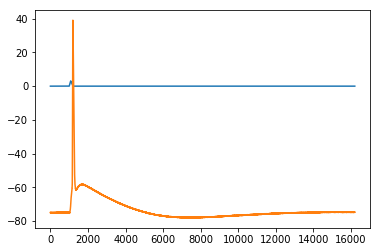

In [5]:
plt.plot(i_inj[0]);
plt.plot(v);

In [6]:
v[10000]
time[10000]



100.0

## generate syntetic data

In [7]:
params, labels = obs_params_gbar(reduced_model=True)
params = params*10
# I, t, t_on, t_off = syn_current(duration=120, dt=dt)

In [8]:
labels

['gbar_nap', 'gbar_leak']

In [9]:
dap = DAPcython(-75, params)
U = dap.simulate(dt, time, i_inj[0], noise=True, noise_fact=1e-2)
u = U.reshape(-1)

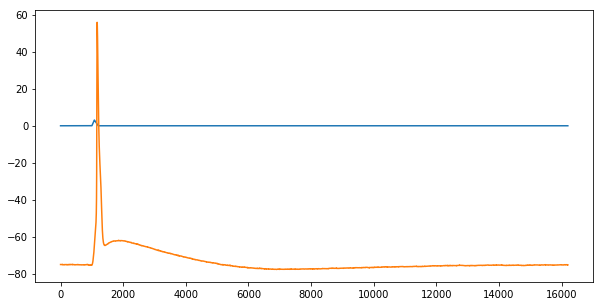

In [10]:
plt.figure(figsize=(10,5))
plt.plot(i_inj[0]);
plt.plot(u);

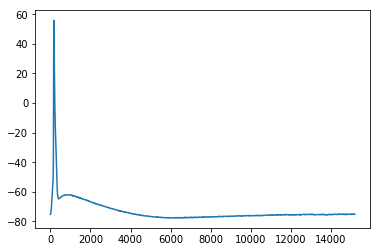

In [11]:
x = {'data': U}
v_dap = np.copy(np.array(x['data']))
v_x = v_dap[np.array(time > t_on)]
plt.plot(v_x);

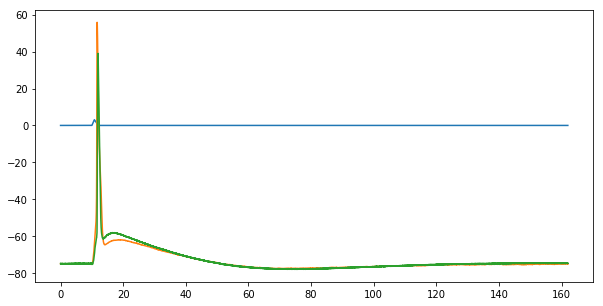

In [12]:
plt.figure(figsize=(10,5))
plt.plot(time, i_inj[0]);
plt.plot(time, u);
plt.plot(time, v);

### Sumstats 

In [13]:
sum_stats_mom = DAPSummaryStatsMoments(t_on, t_off, n_summary=17)

In [14]:
# generate data format for summary statistcs
x_o = {'data': v.reshape(-1),
       'time': time,
       'dt': time[1]-time[0],
       'I': i_inj[0]}

x_1 = {'data': U.reshape(-1),
       'time': time,
       'dt': time[1]-time[0],
       'I': i_inj[0]}

In [15]:
sum_stats_mom.calc([x_o])

(17,)


array([[-74.93,  0.05, -73.19,  0.51,  0.42,  0.44,  0.43,  1311.76,
         1.03,  2.65,  4.78,  40.61,  1.03,  2.59,  4.66,  11.93,  38.91]])

In [16]:
sum_stats_mom.calc([x_1])

(17,)


array([[-75.09,  0.04, -73.31,  0.55,  0.30,  0.28,  0.29,  1541.06,
         0.76,  2.47,  3.88,  30.76,  1.18,  4.04,  14.15,  11.67,
         55.88]])

In [17]:
rest_pot1 = np.mean(x['data'][time<t_on])

# find relevant lenght of the trace (for now from t_on till the end)
v_dap1 = np.array(x_1['data'])
v_dap1 = v_dap1[(time>t_on)]

# TODO: optionally cut the tail as well but might not work with
# bad trace: use v2 instead of dap for further calcualtions
# ind1 = np.where(v_dap1 > rest_pot1)
# v21 = v_dap1[:ind1[0][-1]]

In [18]:
rest_pot = np.mean(x['data'][time<t_on])

# find relevant lenght of the trace (for now from t_on till the end)
v_dap = np.array(x_o['data'])
v_dap = v_dap[(time>t_on)]

# TODO: optionally cut the tail as well but might not work with
# bad trace: use v2 instead of dap for further calcualtions
# ind = np.where(v_dap > rest_pot)
# v2 = v_dap[ind[0][0]:ind[0][-1]]
# ind1 = np.where(v_dap1 > rest_pot1)
# v21 = v_dap1[:ind[0][-1]]

### Different approach: just time

In [19]:
v_dap1 = np.array(x_1['data'])
vA1 = v_dap1[(time >= t_on) & (time <= t_off+1)]
vB1 = v_dap1[(time > t_off+1) & (time < 100)]
_v_dap1 = v_dap1[(time > t_on)]

v_dap = np.array(x_o['data'])
vA = v_dap[(time >= t_on) & (time <= t_off+1)]
vB = v_dap[(time >= t_off+1) & (time < 100)]
_v_dap = v_dap[(time > t_on)]


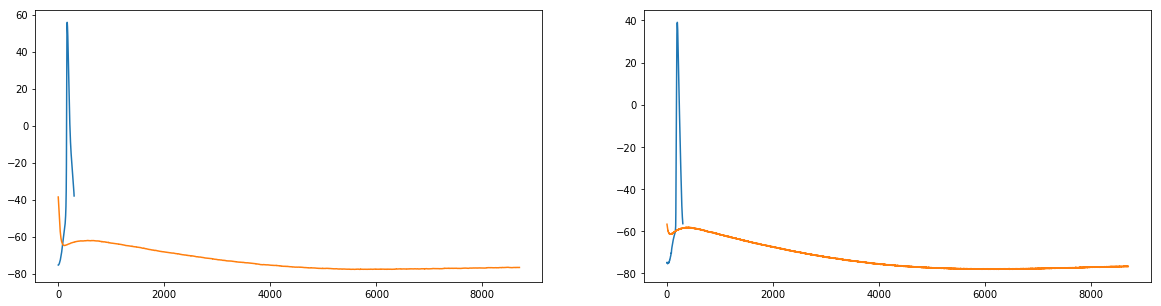

In [20]:
# plt.plot(x['data']);
fig, ax = plt.subplots(1,2,figsize=(20,5))
# ax[0].plot(_v_dap1)
ax[0].plot(vA1);
ax[0].plot(vB1);
# ax[1].plot(_v_dap)
ax[1].plot(vA);
ax[1].plot(vB);
# ax[1].plot(np.gradient(v2))

### Fully Synthetic Data

In [21]:
dt = 0.01
params, labels = obs_params_gbar(reduced_model=True)
params = params*10
I, time, t_on, t_off = syn_current(duration=120, dt=0.01)
t_on

55

In [22]:
dap = DAPcython(-75, params)
U = dap.simulate(dt, time, I, noise=True, noise_fact=1e-4)
u = U.reshape(-1)

In [23]:
x_2 = {'data': U.reshape(-1),
       'time': time,
       'dt': time[1]-time[0],
       'I': I}

In [24]:
c = sum_stats_mom.calc([x_2])
c

(17,)


array([[-75.09,  0.00, -71.88,  0.55,  0.25,  0.18,  0.18,  0.00, -0.13,
         1.87, -0.47,  136.04,  6.45,  56.49,  526.38,  57.44,  56.28]])

In [25]:
v_dap2 = np.array(x_2['data'])
vA2 = v_dap2[(time >= t_on) & (time <= t_off+1)]
vB2 = v_dap2[(time >= t_off+1) & (time < 100)]
_v_dap2 = v_dap2[(time > t_on)]


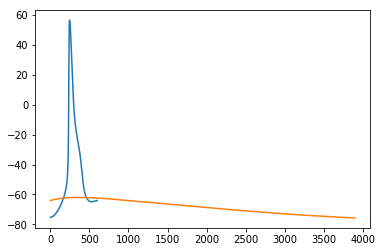

In [26]:
plt.plot(vA2)
plt.plot(vB2)